# House Price Prediction
- 출처 : https://www.kaggle.com/competitions/2019-2nd-ml-month-with-kakr

- 집의 정보를 이용하여 가격을 예측하는 방식 (Regression 문제)
- RMSE를 이용하여 모델의 정확도를 평가함

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb 

import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 불러오기

In [2]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
print(train.shape, test.shape)
train.head()

(15035, 21) (6468, 20)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- 15035의 train 데이터와 6468개의 test 데이터셋으로 이루어져있다

## EDA

### 데이터 살펴보기

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

    ID : 집을 구분하는 번호
    date : 집을 구매한 날짜
    price : 타겟 변수인 집의 가격
    bedrooms : 침실의 수
    bathrooms : 침실당 화장실 개수
    sqft_living : 주거 공간의 평방 피트
    sqft_lot : 부지의 평방 피트
    floors : 집의 층 수
    waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
    view : 집이 얼마나 좋아 보이는지의 정도
    condition : 집의 전반적인 상태
    grade : King County grading 시스템 기준으로 매긴 집의 등급
    sqft_above : 지하실을 제외한 평방 피트
    sqft_basement : 지하실의 평방 피트
    yr_built : 집을 지은 년도
    yr_renovated : 집을 재건축한 년도
    zipcode : 우편번호
    lat : 위도
    long : 경도
    sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
    sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

- 문자열 type의 데이터는 없고 모두 수치형 데이터로 구성되어있다.
- date가 object 타입이긴한데 데이터 특성상 시계열 데이터이므로 datetime 형태로 변환해 줄 것이다
- 수치형 데이터이더라도 이진분류가 되는 binary 형태나 등급같은 것은 범주형 데이터의 형태일 것으로 보인다.
    - 수치형과 범주형 데이터를 나눠서 분석을 해줄 것이다

## ID : 집을 구분하는 번호

In [5]:
train.shape

(15035, 21)

In [6]:
train.id.nunique()

15035

- id의 값은 unique 하므로 인덱스와 일치하기에 id를 index로 변경하거나 없애주어도 된다
- test data도 동일하게 전처리를 진행한다

In [7]:
# id를 index로
# train.set_index('id', inplace=True)
# test.set_index('id', inplace=True)

In [8]:
del train['id']
del test['id']

In [9]:
train.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [10]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


## date : 집을 구매한 날짜

In [11]:
train['date'][0]

'20141013T000000'

In [12]:
train['date'].str.split('T').str[1].unique()

array(['000000'], dtype=object)

- T 뒤에는 의미없는 숫자들인 것 같고 앞에는 날짜정보를 가지고 있으므로 전처리를 통해 datetime형식으로 변환해준다

In [13]:
def extract_date_info(train):
    # 날짜 정보 분리 후 datetime으로 형식 변환
    train['date'] = train['date'].str.split('T').str[0]
    train['date'] = pd.to_datetime(train['date'])

    # 시간 관련 여러 파생변수 추출
    train['year'] = train.date.dt.year
    train['month'] = train.date.dt.month
    train['day'] = train.date.dt.day

    train['day_of_week'] = train.date.dt.day_of_week
    train['day_name'] = train.date.dt.day_name()
    train['quarter'] = train.date.dt.quarter
    
    train.drop('date', axis=1, inplace=True)

In [14]:
extract_date_info(train)

In [15]:
train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,lat,long,sqft_living15,sqft_lot15,year,month,day,day_of_week,day_name,quarter
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,47.5112,-122.257,1340,5650,2014,10,13,0,Monday,4
1,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,47.7379,-122.233,2720,8062,2015,2,25,2,Wednesday,1
2,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,47.6168,-122.045,1800,7503,2015,2,18,2,Wednesday,1
3,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,...,47.3097,-122.327,2238,6819,2014,6,27,4,Friday,2
4,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,...,47.4095,-122.315,1650,9711,2015,1,15,3,Thursday,1


In [16]:
# test data에도 마찬가지로 같이 전처리를 해준다
extract_date_info(test)

### 시간 관련 변수 시각화

In [17]:
date_col = ['year','month','day','day_of_week','day_name','quarter']

In [18]:
train[date_col]

,year,month,day,day_of_week,day_name,quarter
0,2014,10,13,0,Monday,4
1,2015,2,25,2,Wednesday,1
2,2015,2,18,2,Wednesday,1
3,2014,6,27,4,Friday,2
4,2015,1,15,3,Thursday,1
...,...,...,...,...,...,...
15030,2014,10,14,1,Tuesday,4
15031,2015,3,26,3,Thursday,1
15032,2014,5,21,2,Wednesday,2
15033,2015,2,23,0,Monday,1


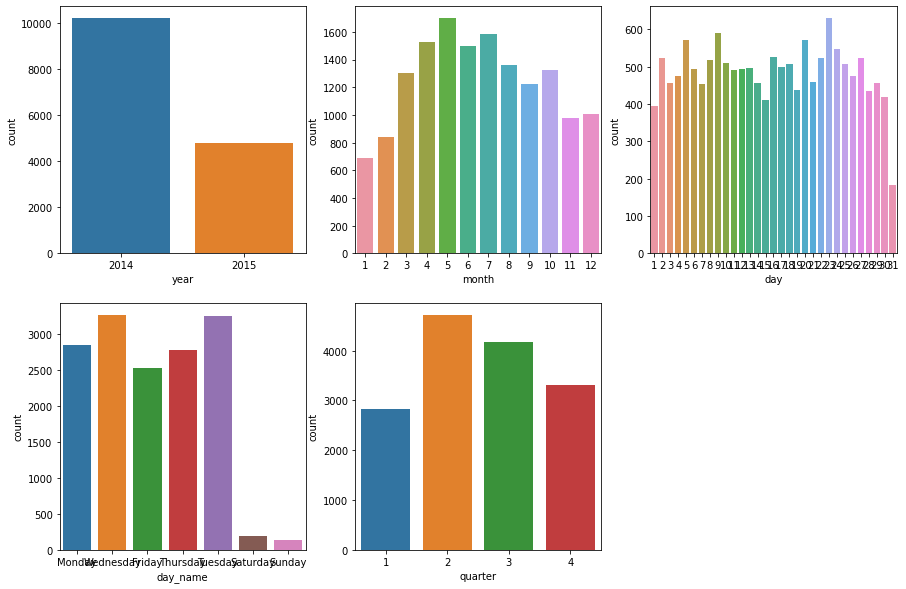

In [19]:
plt.figure(figsize = (15,10))

for i, col in enumerate(['year','month','day','day_name','quarter']):
    plt.subplot(2,3,i+1)
    sns.countplot(train[col])

- 2014년에 비해 2015년에 집 구매가 줄었다
- 5, 6, 7월에 주로 집을 구매하며 1월, 2월, 11월, 12월의 구매가 현저히 적다
- 31일이 없는 달도 있으므로 31일이 적은 것은 당연한 수치이지만 1일은 확실히 적은 수치인 것 같다.
- 구매일자는 주로 평일이 많고 주말에는 구매를 잘 하지 않는다는 것을 볼 수 있다
    - 부동산 매매업이 주로 평일에 영업을 해서 그런것으로 추정된다. 그렇다하더라도 수요일에는 구매가 적고 금요일에 구매가 많이 이루어진다
- 분기별로 비교했을 때, 2,3분기에 주로 구매한다

## price : 타겟 변수인 집의 가격
- price는 타겟 변수이므로 y에 할당해준다

In [20]:
y = train['price']

# 데이터 분석을 위해 아직 지우지는 않는 것이 편할 것 같아 지우지 않을 것이다
# train.drop('price', axis=1, inplace=True)
# train.columns

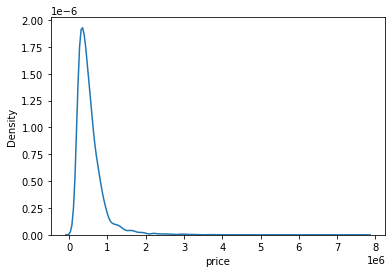

In [21]:
# y의 분포 확인

sns.kdeplot(y)
plt.show()

- price는 왼쪽으로 크게 치우쳐 있는 형태를 보인다.

따라서 y는 np.log1p() 함수를 통해 로그 변환을 해주고, 나중에 모델이 값을 예측한 후에 다시 np.expm1()을 활용해서 되돌려 줄 것이다. 

In [22]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

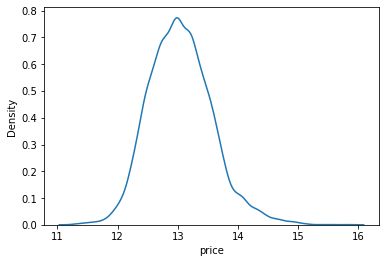

In [23]:
sns.kdeplot(y)
plt.show()

## bedrooms : 침실의 수, bathrooms : 침실당 화장실 개수

In [24]:
cols = ['bedrooms', 'bathrooms']

In [25]:
train[col].describe()

count    15035.000000
mean         2.528833
std          1.032473
min          1.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          4.000000
Name: quarter, dtype: float64

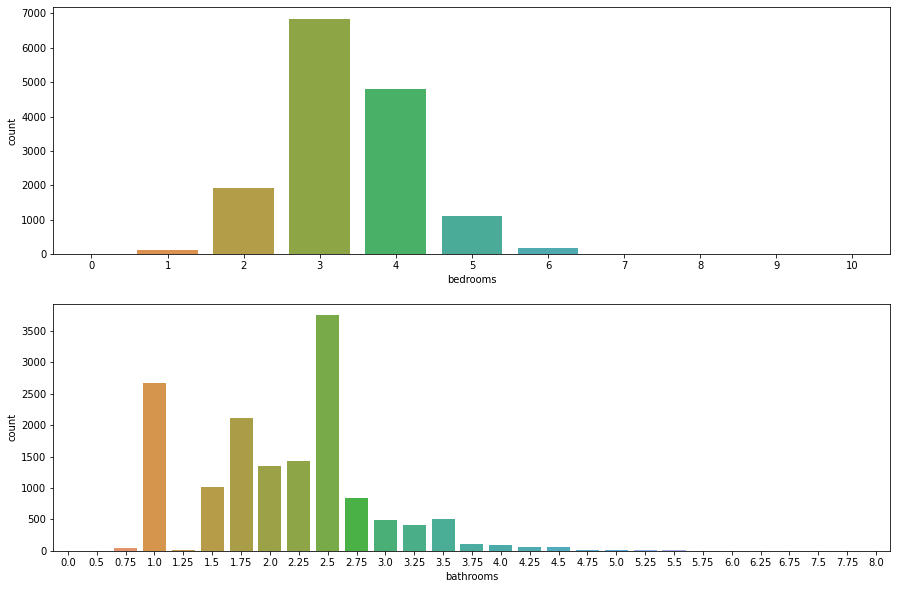

In [26]:
plt.figure(figsize = (15,10))

for i, col in enumerate(cols):
    plt.subplot(2,1,i+1)
    sns.countplot(train[col])

### 방의 개수와 화장실의 개수의 관계

<AxesSubplot:xlabel='bedrooms', ylabel='bathrooms'>

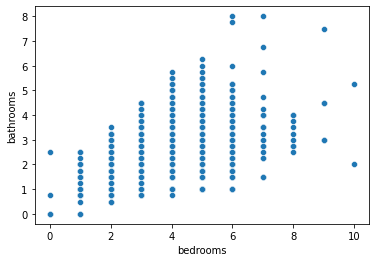

In [27]:
sns.scatterplot(x='bedrooms', y='bathrooms', data=train)

- 여기서 최솟값인 0인 데이터가 눈에 띈다 방이 침실과 화장실이 없는 데이터는 무엇일까?
- 그리고 화장실에서 0.5 값은 무엇일까?

원본 데이터를 확인 해봤다
- bathrooms : Number of bathrooms, where .5 accounts for a room with a toilet but no shower
- 변기만 있고 shower 공간이 없는 화장실을 .5로 본다고 써있었다

In [28]:
train[(train.bedrooms == 0) | (train.bathrooms == 0)]

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,lat,long,sqft_living15,sqft_lot15,year,month,day,day_of_week,day_name,quarter
4123,280000.0,1,0.00,600,24501,1.0,0,0,2,3,...,47.5316,-121.749,990,22549,2014,11,4,1,Tuesday,4
6885,235000.0,0,0.00,1470,4800,2.0,0,0,3,7,...,47.5265,-121.828,1060,7200,2014,12,23,1,Tuesday,4
7322,484000.0,1,0.00,690,23244,1.0,0,0,4,7,...,47.6429,-121.955,1690,19290,2014,9,18,3,Thursday,3
8826,320000.0,0,2.50,1490,7111,2.0,0,0,3,7,...,47.5261,-121.826,1500,4675,2015,2,18,2,Wednesday,1
12781,265000.0,0,0.75,384,213444,1.0,0,0,3,4,...,47.4177,-122.491,1920,224341,2014,10,29,2,Wednesday,4
13522,142000.0,0,0.00,290,20875,1.0,0,0,1,1,...,47.5308,-121.888,1620,22850,2014,9,26,4,Friday,3


- 확실히 방이 0개인데 화장실이 2.5개인 집은 상당히 이상한 데이터로 보인다.
- 일단 6개이므로 제거해준다

In [29]:
odd_index = train[(train.bedrooms == 0) | (train.bathrooms == 0)].index

In [30]:
train.drop(odd_index, inplace=True)

In [31]:
train.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,day_of_week,quarter
count,1.502900e+04,15029.000000,15029.000000,15029.000000,1.502900e+04,15029.000000,15029.000000,15029.000000,15029.000000,15029.000000,...,15029.000000,15029.000000,15029.000000,15029.000000,15029.000000,15029.000000,15029.000000,15029.000000,15029.000000,15029.000000
mean,5.407837e+05,3.370351,2.115693,2084.294497,1.528351e+04,1.498137,0.007120,0.234347,3.406947,7.661854,...,98078.041453,47.560733,-122.213780,1992.966132,12808.982966,2014.319715,6.579679,15.693459,2.000599,2.528578
std,3.715587e+05,0.900811,0.766809,921.921821,4.259039e+04,0.538537,0.084079,0.763514,0.646190,1.177758,...,53.305306,0.138184,0.141142,691.481161,27687.680801,0.466382,3.105970,8.649716,1.448545,1.032380
min,7.800000e+04,1.000000,0.500000,380.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,...,98001.000000,47.155900,-122.519000,399.000000,651.000000,2014.000000,1.000000,1.000000,0.000000,1.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.027000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,...,98033.000000,47.472700,-122.328000,1490.000000,5100.000000,2014.000000,4.000000,8.000000,1.000000,2.000000
50%,4.500000e+05,3.000000,2.250000,1920.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,...,98065.000000,47.571900,-122.231000,1850.000000,7609.000000,2014.000000,6.000000,16.000000,2.000000,2.000000
75%,6.450000e+05,4.000000,2.500000,2560.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,...,98117.000000,47.678400,-122.126000,2360.000000,10075.000000,2015.000000,9.000000,23.000000,3.000000,3.000000
max,7.700000e+06,10.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,...,98199.000000,47.777600,-121.315000,6210.000000,871200.000000,2015.000000,12.000000,31.000000,6.000000,4.000000


<AxesSubplot:xlabel='bedrooms', ylabel='bathrooms'>

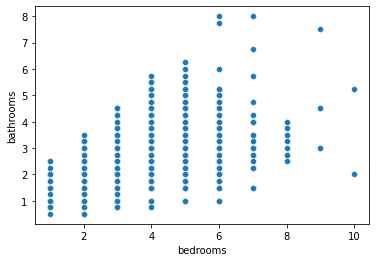

In [32]:
sns.scatterplot(x='bedrooms', y='bathrooms', data=train)

- 0.75는 또 뭐일까 싶긴하지만 일단 여기까지만 하고 넘어가주자

### 평방 피트 관련 데이터
- sqft_living : 주거 공간의 평방 피트
- sqft_lot : 부지의 평방 피트
- sqft_above : 지하실을 제외한 평방 피트
- sqft_basement : 지하실의 평방 피트
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [33]:
sqft_df = train.loc[:,train.columns.str.contains('sqft')]

In [34]:
sqft_df.describe()

,sqft_living,sqft_lot,sqft_above,sqft_basement,sqft_living15,sqft_lot15
count,15029.000000,1.502900e+04,15029.000000,15029.000000,15029.000000,15029.000000
mean,2084.294497,1.528351e+04,1794.546810,289.747688,1992.966132,12808.982966
std,921.921821,4.259039e+04,831.620781,440.713233,691.481161,27687.680801
min,380.000000,5.200000e+02,380.000000,0.000000,399.000000,651.000000
25%,1430.000000,5.027000e+03,1190.000000,0.000000,1490.000000,5100.000000
50%,1920.000000,7.620000e+03,1570.000000,0.000000,1850.000000,7609.000000
75%,2560.000000,1.068800e+04,2230.000000,550.000000,2360.000000,10075.000000
max,13540.000000,1.651359e+06,9410.000000,4130.000000,6210.000000,871200.000000


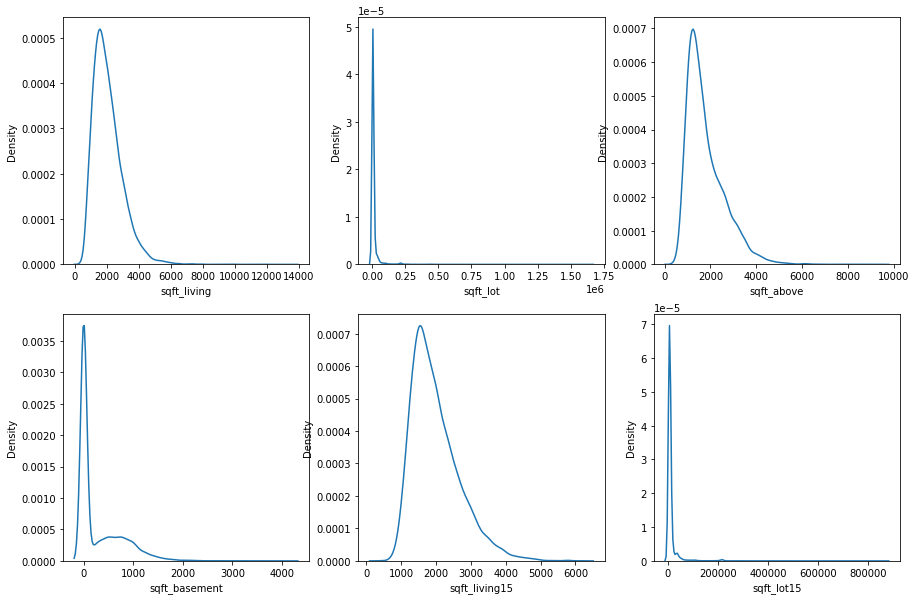

In [35]:
plt.figure(figsize = (15,10))

for i, col in enumerate(sqft_df.columns):
    plt.subplot(2,3,i+1)
    sns.kdeplot(train[col])

- 15년 데이터는 sqft_living15, sqft_lot15, 14년 데이터는 sqft_living, sqft_lot을 써야하지 않을까?
- 지하실은 0인 데이터가 상당히 많아 보인다. 지하실이 있고 없고를 기준으로 파생변수를 만들어도 되지 않을까?

### 지하실이 있는집과 없는 집의 집값 차이는?

In [36]:
(train['sqft_basement'] > 0).value_counts()

False    9137
True     5892
Name: sqft_basement, dtype: int64

In [37]:
train['basement_yn'] = train['sqft_basement'] > 0

In [38]:
test['basement_yn'] = test['sqft_basement'] > 0

<AxesSubplot:xlabel='basement_yn', ylabel='price'>

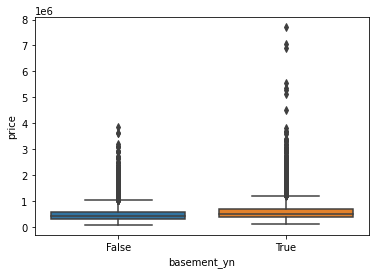

In [39]:
sns.boxplot(y='price', x='basement_yn', data=train)

- 확실히 집 값이 비싼 집은 모두 지하실이 있는 것으로 보인다

### 15년에 재개발을 한 집은?

In [40]:
sqft_df.columns

Index(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [41]:
def calc_diff(train):
    train['sqft_living_diff'] = train['sqft_living15'] - train['sqft_living']
    train['sqft_lot_diff'] = train['sqft_lot15'] - train['sqft_lot']

In [42]:
calc_diff(train)
calc_diff(test)

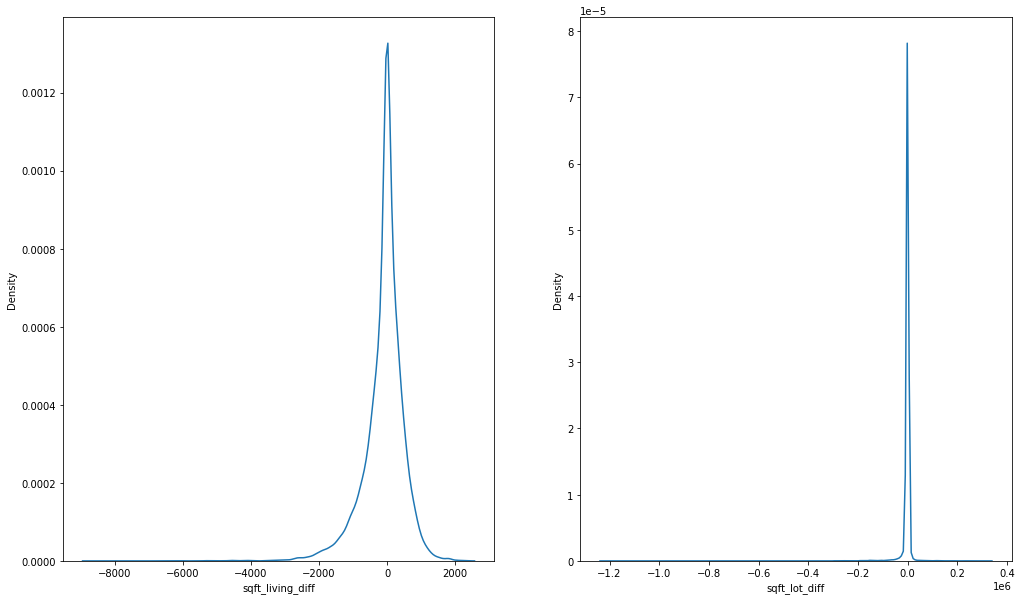

In [43]:
plt.figure(figsize = (17,10))

for i, col in enumerate(train.loc[:,train.columns.str.contains('diff')].columns):
    plt.subplot(1,2,i+1)
    sns.kdeplot(train[col])

- 너무 많이 줄어든 것들이 이상하다

In [44]:
(train.loc[:,train.columns.str.contains('diff')] != 0).value_counts()

sqft_living_diff  sqft_lot_diff
True              True             10496
                  False             2756
False             True              1418
                  False              359
dtype: int64

- 대다수의 값들이 부지크기가 변화한 것을 볼 수 있다
- 재개발을 하게 되면 집값이 상승할 수도 있지않을까? 하는 생각이 들었다.
- 이에 따라서 재개발에 대한 기대감으로 2014년에 계약했더라도 집값이 높게 측정될 수도 있다는 생각이 들어서 이 고민을 하게 되었다.
- 지금은 조금 복잡한 전처리가 될 것으로 보여지기에 추후 다시 생각해보기로 결정했다.

- 이번에는 2014년에 계약을 했다면 2014년 값을 쓰고 2015년에 계약했다면 2015년 값을 쓰는 데이터의 전처리만을 하고자한다.

### 2014년에 계약을 했다면 2014년 값을 쓰고 2015년에 계약했다면 2015년 값을 사용
- 실험 결과 성능이 낮아져 생략

In [45]:
sqft_df.columns

Index(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [46]:
def preprocessing_sqft(df):
    df['selected_sqft_living'] = np.where(df['year'] == 2014, df['sqft_living'], df['sqft_living15'])
    df['selected_sqft_lot'] = np.where(df['year'] == 2014, df['sqft_lot'], df['sqft_lot15'])
    df.drop(['sqft_living','sqft_living15','sqft_lot','sqft_lot15'], axis=1, inplace=True)
    # 합쳐준 이름을 'sqft_living','sqft_lot'으로 바꿔준다
    df.columns = df.columns.str.replace('selected_','')

In [47]:
# preprocessing_sqft(train)
# preprocessing_sqft(test)

In [48]:
# train.drop(['sqft_living','sqft_living15','sqft_lot','sqft_lot15'], axis=1, inplace=True)
train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_lot15,year,month,day,day_of_week,day_name,quarter,basement_yn,sqft_living_diff,sqft_lot_diff
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,5650,2014,10,13,0,Monday,4,False,160,0
1,180000.0,2,1.00,770,10000,1.0,0,0,3,6,...,8062,2015,2,25,2,Wednesday,1,False,1950,-1938
2,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,...,7503,2015,2,18,2,Wednesday,1,False,120,-577
3,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,...,6819,2014,6,27,4,Friday,2,False,523,0
4,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,...,9711,2015,1,15,3,Thursday,1,False,590,0


## 집 정보 관련 피처
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)

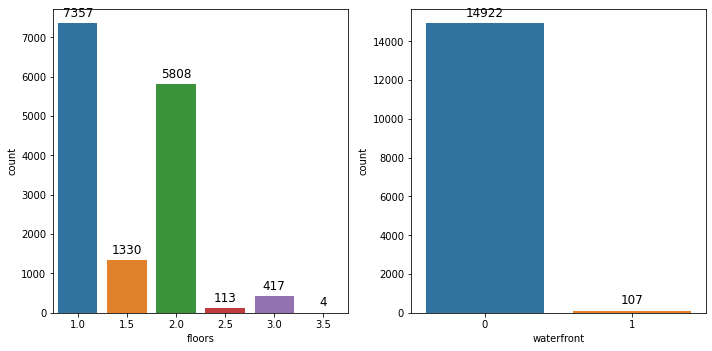

In [49]:
plt.figure(figsize=(10,5))

for i, col in enumerate(['floors', 'waterfront']):
    plt.subplot(1, 2, i+1)
    plot = sns.countplot(x=train[col])
    
    # 막대 위에 실제 수치 추가
    for p in plot.patches:
        plot.annotate(f'{p.get_height()}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 10), 
                      textcoords='offset points',
                      fontsize=12, color='black')

plt.tight_layout()
plt.show()

## 집 위치 정보 피처
- zipcode : 우편번호
- lat : 위도
- long : 경도

### 우편번호 별 집값 분포 시각화

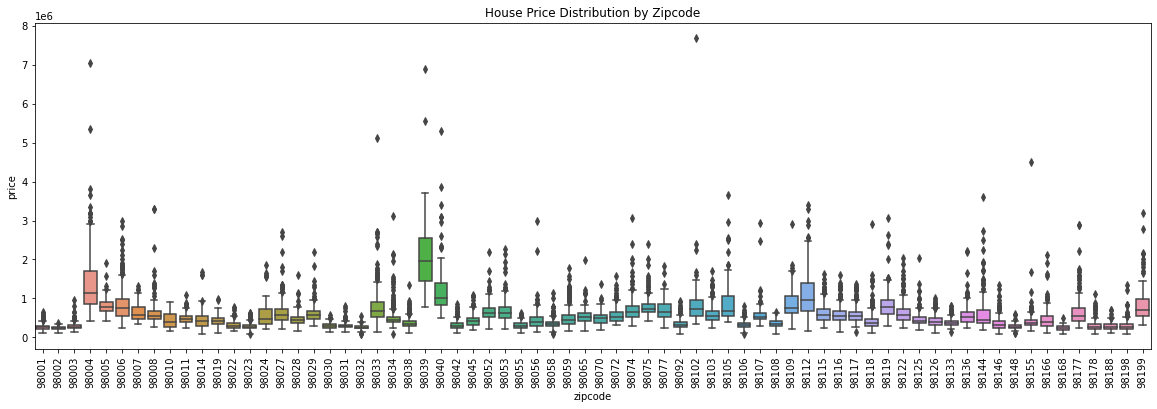

In [50]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='zipcode', y='price', data=train)
plt.title('House Price Distribution by Zipcode')
plt.xticks(rotation=90)
plt.show()

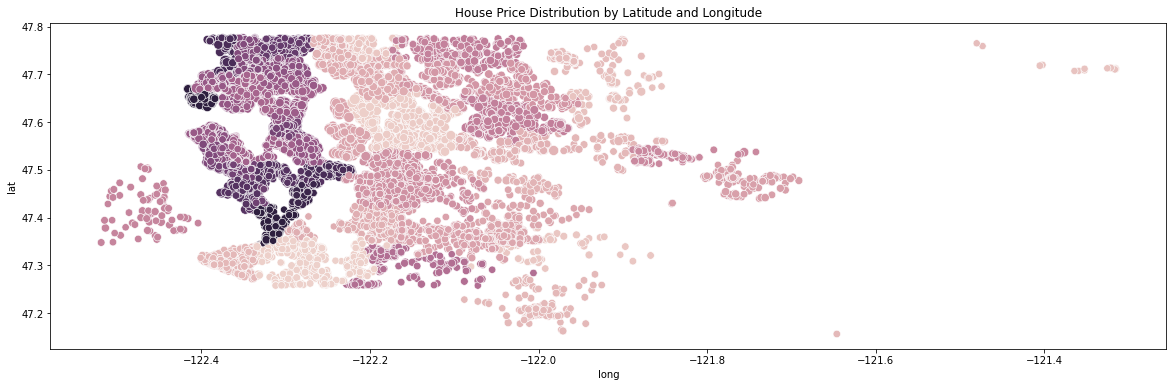

In [51]:
plt.figure(figsize=(20, 6))
sns.scatterplot(x='long', y='lat', hue='zipcode', size='price', sizes=(50, 200), data=train, legend=None)
plt.title('House Price Distribution by Latitude and Longitude')
plt.show()

- 확실히 zipcode는 위도와 경도(위치)에 따라 붙어있음을 알 수 있다

### 위도와 경도에 따른 집값 시각화

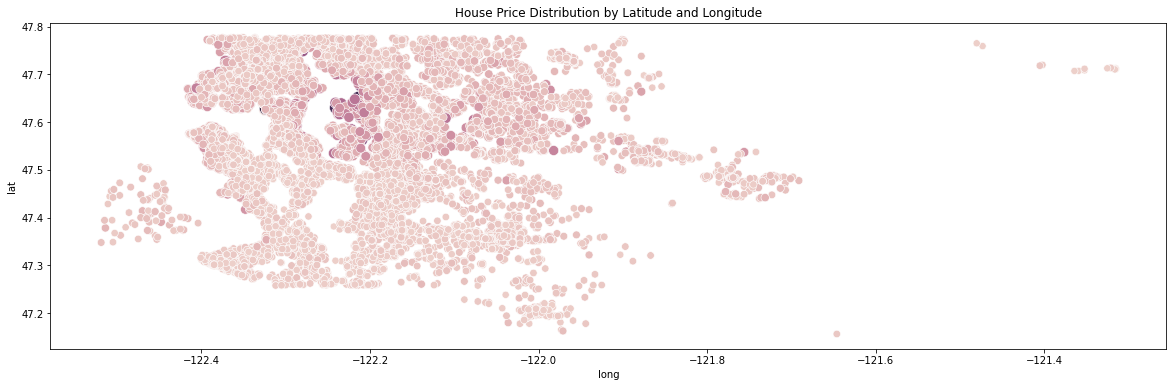

In [52]:
plt.figure(figsize=(20, 6))
sns.scatterplot(x='long', y='lat', hue='price', size='price', sizes=(50, 200), data=train, legend=None)
plt.title('House Price Distribution by Latitude and Longitude')
plt.show()

### 파생변수 생성
- 위치 관련 정보가 담긴 파생변수가 성능을 높이는데 주요 요인이 될 것 같았다
- zipcode별 집값의 중앙값을 파생변수로 생성한다
- 평균을 이용한다면 이상치의 영향을 받을 수도 있기에 중앙값을 이용하였다
    - 생각보다 성능개선의 효과가 없어 다른 코드를 참고해 추가하였다

In [53]:
median_price_by_zipcode = train.groupby('zipcode')['price'].median().reset_index()
median_price_by_zipcode.columns = ['zipcode', 'median_price']
train = train.merge(median_price_by_zipcode, on='zipcode')

In [54]:
# test data에도 같은 처리를 해준다
test = test.merge(median_price_by_zipcode, on='zipcode')

In [55]:
train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,year,month,day,day_of_week,day_name,quarter,basement_yn,sqft_living_diff,sqft_lot_diff,median_price
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,2014,10,13,0,Monday,4,False,160,0,273500.0
1,205425.0,2,1.00,880,6780,1.0,0,0,4,6,...,2014,6,23,0,Monday,2,False,310,0,273500.0
2,445000.0,3,2.25,2100,8201,1.0,0,2,3,8,...,2014,7,17,3,Thursday,3,True,560,511,273500.0
3,170000.0,2,1.00,860,5265,1.0,0,0,3,6,...,2015,2,27,4,Friday,1,False,790,3510,273500.0
4,245000.0,3,1.75,1740,11547,1.0,0,0,3,7,...,2015,5,1,4,Friday,2,False,-860,66861,273500.0


### 연도 관련 피처
- yr_built : 집을 지은 년도
- yr_renovated : 집을 재건축한 년도

In [56]:
train[['yr_built', 'yr_renovated']].describe()

,yr_built,yr_renovated
count,15029.000000,15029.000000
mean,1971.098277,83.832391
std,29.409568,400.474919
min,1900.000000,0.000000
25%,1951.000000,0.000000
50%,1975.000000,0.000000
75%,1997.000000,0.000000
max,2015.000000,2015.000000


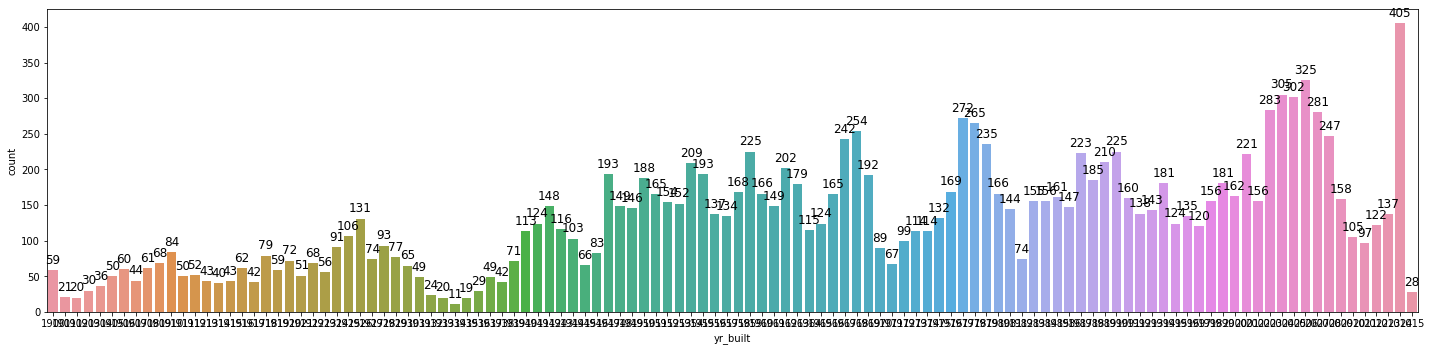

In [57]:
plt.figure(figsize=(20,5))
plot = sns.countplot(x=train['yr_built'])

# 막대 위에 실제 수치 추가
for p in plot.patches:
    plot.annotate(f'{p.get_height()}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 10), 
                  textcoords='offset points',
                  fontsize=12, color='black')

plt.tight_layout()
plt.show()

- 생각보다 오래된 건물들이 많이 있었다

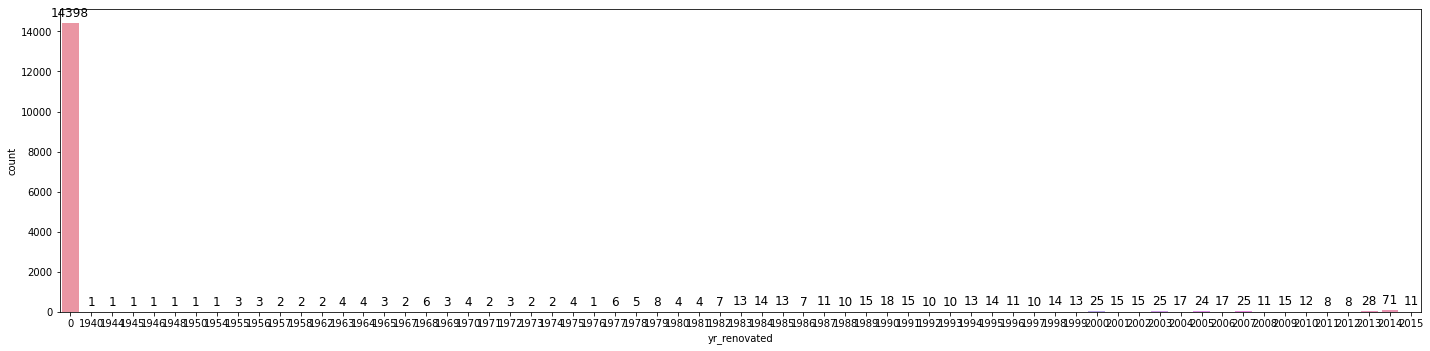

In [58]:
plt.figure(figsize=(20,5))
plot = sns.countplot(x=train['yr_renovated'])

# 막대 위에 실제 수치 추가
for p in plot.patches:
    plot.annotate(f'{p.get_height()}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 10), 
                  textcoords='offset points',
                  fontsize=12, color='black')

plt.tight_layout()
plt.show()

- 재건축을 안한 집이 많아서 잘 보이지 않는다

0을 빼고 다시 시각화를 진행하였다

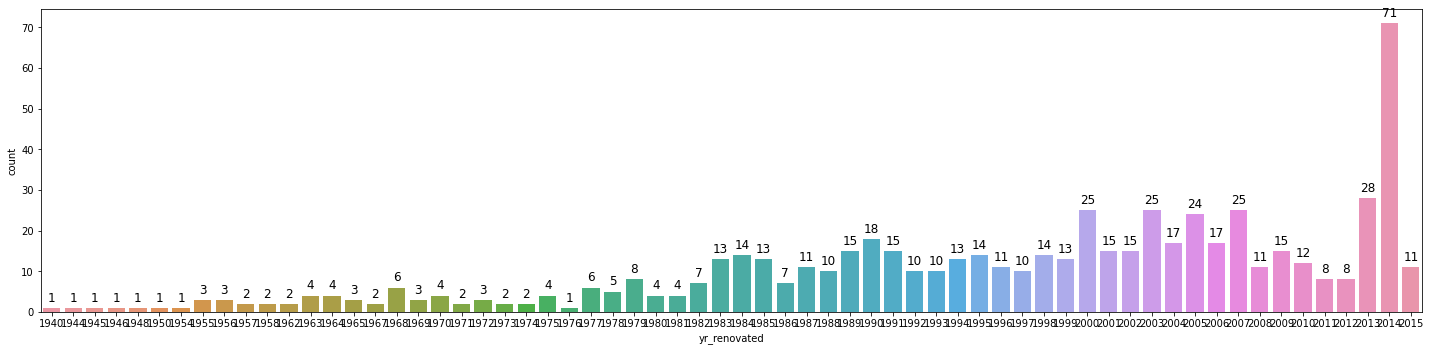

In [59]:
plt.figure(figsize=(20,5))
plot = sns.countplot(x=train.loc[train['yr_renovated']>0,'yr_renovated'])

# 막대 위에 실제 수치 추가
for p in plot.patches:
    plot.annotate(f'{p.get_height()}', 
                  (p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha='center', va='center', 
                  xytext=(0, 10), 
                  textcoords='offset points',
                  fontsize=12, color='black')

plt.tight_layout()
plt.show()

- 2014년에 재건축이 많았다

### 재건축 여부도 파생변수로 추가

In [60]:
train['renovated_yn'] = train['yr_renovated'] > 0
test['renovated_yn'] = test['yr_renovated'] > 0

### 파생변수 생성
**집 나이 계산**:
   - `np.where` 함수를 사용하여 조건을 설정하여 집 나이를 계산한다.
     - 만약 `yr_renovated` 값이 `0`이 아니면, 즉 재건축이 되었으면 `year - yr_renovated`를 계산한다.
     - 그렇지 않으면 `year - yr_built`를 계산한다.
   - 이를 통해 `house_age`라는 새로운 컬럼을 생성

In [61]:
def calc_age(df):
    df['house_age'] = np.where(df['yr_renovated'] != 0, df['year'] - df['yr_renovated'], df['year'] - df['yr_built'])

In [62]:
calc_age(train)

In [63]:
calc_age(test)

### 집에 대한 평가 피처
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급

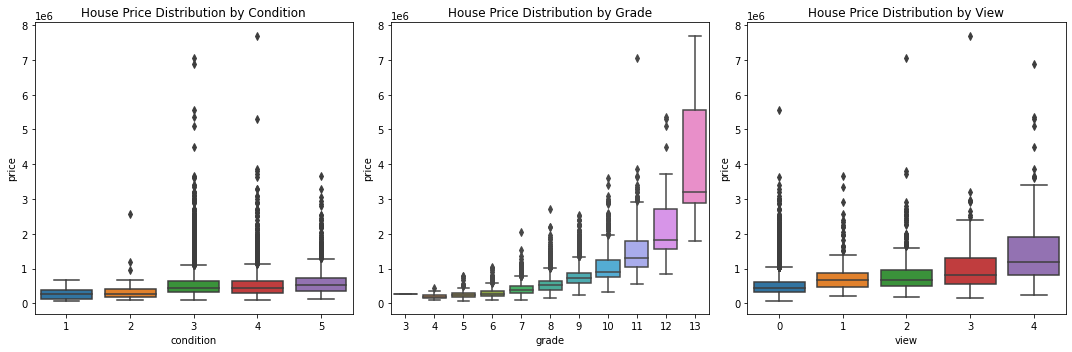

In [64]:
# 1. Condition별 집값 분포 시각화
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(x='condition', y='price', data=train)
plt.title('House Price Distribution by Condition')

# 2. Grade별 집값 분포 시각화
plt.subplot(1, 3, 2)
sns.boxplot(x='grade', y='price', data=train)
plt.title('House Price Distribution by Grade')

# 3. View 등급별 집값 분포 시각화
plt.subplot(1, 3, 3)
sns.boxplot(x='view', y='price', data=train)
plt.title('House Price Distribution by View')

plt.tight_layout()
plt.show()

- 확실히 집 상태의 평가가 높아지면 더 값이 비싸지는 경향을 볼 수 있다

### 파생변수 생성
- view, condition, grade의 평균을 파생변수로 생성하고자 한다

In [65]:
def get_score(df):
    df['score'] = df[['view', 'condition', 'grade']].mean(axis=1)

In [66]:
get_score(train)

In [67]:
get_score(test)

## 피처 선정

In [68]:
train

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,day_of_week,day_name,quarter,basement_yn,sqft_living_diff,sqft_lot_diff,median_price,renovated_yn,house_age,score
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,0,Monday,4,False,160,0,273500.0,False,59,3.333333
1,205425.0,2,1.00,880,6780,1.0,0,0,4,6,...,0,Monday,2,False,310,0,273500.0,False,69,3.333333
2,445000.0,3,2.25,2100,8201,1.0,0,2,3,8,...,3,Thursday,3,True,560,511,273500.0,False,47,4.333333
3,170000.0,2,1.00,860,5265,1.0,0,0,3,6,...,4,Friday,1,False,790,3510,273500.0,False,84,3.000000
4,245000.0,3,1.75,1740,11547,1.0,0,0,3,7,...,4,Friday,2,False,-860,66861,273500.0,False,61,3.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15024,3635000.0,5,6.00,5490,19897,2.0,0,0,3,12,...,5,Saturday,4,False,-2580,-2297,1950000.0,False,9,5.000000
15025,2720000.0,4,3.25,3990,18115,2.0,0,0,4,11,...,4,Friday,4,False,-540,-2028,1950000.0,False,25,5.000000
15026,1950000.0,4,3.50,4065,18713,2.0,0,0,4,10,...,4,Friday,3,False,-995,0,1950000.0,False,27,4.666667
15027,2250000.0,5,5.25,3410,8118,2.0,0,0,3,11,...,1,Tuesday,2,False,0,8118,1950000.0,False,9,4.666667


In [69]:
train.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year', 'month', 'day', 'day_of_week',
       'day_name', 'quarter', 'basement_yn', 'sqft_living_diff',
       'sqft_lot_diff', 'median_price', 'renovated_yn', 'house_age', 'score'],
      dtype='object')

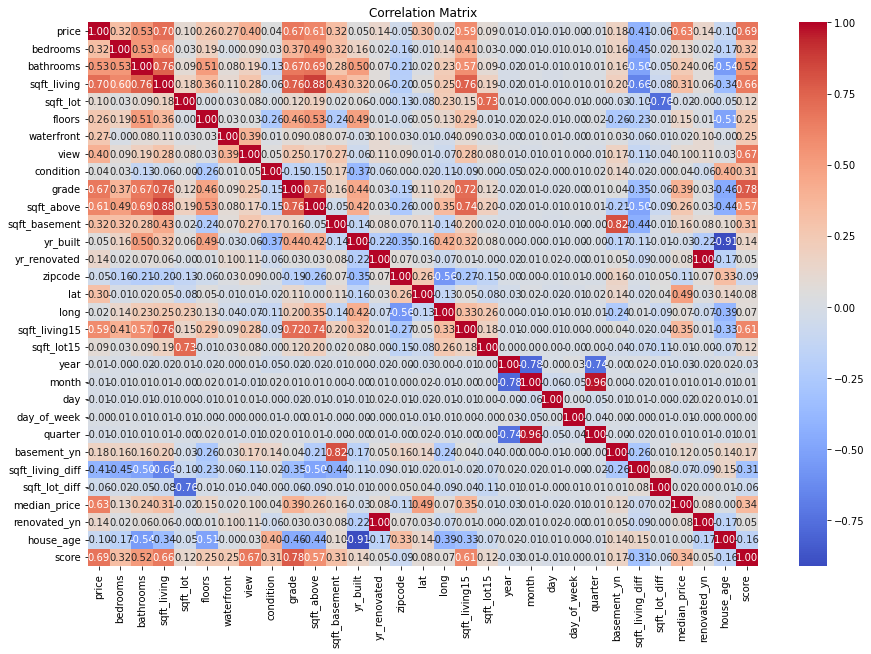

In [70]:
df = train.copy()

## 상관관계 분석
plt.figure(figsize=(15, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

### 상관관계 분석 결과에 따라 필요 없는 컬럼 제거

In [71]:
correlation_matrix.columns[np.abs(correlation_matrix.price) < 0.1]

Index(['sqft_lot', 'condition', 'yr_built', 'zipcode', 'long', 'sqft_lot15',
       'year', 'month', 'day', 'day_of_week', 'quarter', 'sqft_lot_diff'],
      dtype='object')

In [72]:
drop_cols = ['year', 'month', 'day', 'day_of_week', 'day_name','quarter', 'sqft_lot_diff']

In [73]:
train.drop(drop_cols, axis=1, inplace=True)

In [74]:
train.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'basement_yn', 'sqft_living_diff',
       'median_price', 'renovated_yn', 'house_age', 'score'],
      dtype='object')

In [75]:
test.drop(drop_cols, axis=1, inplace=True)

In [76]:
train.shape

(15029, 25)

In [77]:
train.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,lat,long,sqft_living15,sqft_lot15,basement_yn,sqft_living_diff,median_price,renovated_yn,house_age,score
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,...,47.5112,-122.257,1340,5650,False,160,273500.0,False,59,3.333333
1,205425.0,2,1.00,880,6780,1.0,0,0,4,6,...,47.5009,-122.248,1190,6780,False,310,273500.0,False,69,3.333333
2,445000.0,3,2.25,2100,8201,1.0,0,2,3,8,...,47.5091,-122.244,2660,8712,True,560,273500.0,False,47,4.333333
3,170000.0,2,1.00,860,5265,1.0,0,0,3,6,...,47.5048,-122.272,1650,8775,False,790,273500.0,False,84,3.000000
4,245000.0,3,1.75,1740,11547,1.0,0,0,3,7,...,47.4945,-122.220,880,78408,False,-860,273500.0,False,61,3.333333


In [78]:
train.shape

(15029, 25)

In [79]:
test.shape

(6468, 24)

In [80]:
train.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'basement_yn', 'sqft_living_diff',
       'median_price', 'renovated_yn', 'house_age', 'score'],
      dtype='object')

In [81]:
test.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'basement_yn', 'sqft_living_diff',
       'median_price', 'renovated_yn', 'house_age', 'score'],
      dtype='object')

## 모델링

### 모델 및 평가 지표 선정 이유
- 선택한 모델: 앙상블 모델 (랜덤 포레스트, 그래디언트 부스팅, 배깅)
    - 선정 이유: 앙상블 모델은 여러 모델의 예측을 결합하여 예측 성능을 향상시키며, 단일 모델보다 일반화 성능이 뛰어나다.

- 평가 지표: RMSE(Root Mean Squared Error)
    - 선정 이유: RMSE는 예측 값과 실제 값 간의 차이를 제곱한 후 평균을 구해 루트를 취한다. 단위가 타깃 변수의 단위와 같아 해석이 용이하고, 큰 오차에 더 큰 패널티를 부여한다.

In [112]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
y = train['price']
y = np.log1p(y)

del train['id']
del test['id']

In [142]:
skew_columns = ['sqft_living', 'sqft_lot','sqft_living15', 'sqft_lot15', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

In [143]:
for df in [train, test]:
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    # 거실의 비율
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    # 총 면적
    df['sqft_total_size'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement']
    # 면적 대비 거실 비율
#     df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    df['sqft_total15'] = df['sqft_living15'] + df['sqft_lot15']
#     df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_total15'] 

    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x==0 else 1)
    df['date'] = df['date'].astype('int')

In [144]:
train['per_price'] = train['price'] / train['sqft_total_size']
zipcode_price = train.groupby(['zipcode'])['per_price'].agg({'mean', 'var'}).reset_index()
train = pd.merge(train, zipcode_price, how='left', on='zipcode')
test = pd.merge(test, zipcode_price, how='left', on='zipcode')
del train['per_price']

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [146]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [147]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [148]:
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [149]:
X = train.drop('price', axis=1)

In [150]:
def get_scores(models, train, y):
    df = {}

    for model in models:
    # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리
        # random_state를 사용하여 고정하고 train과 test 셋의 비율은 8:2로 합니다.
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, X, y)

,RMSE
RandomForestRegressor,124009.198841
GradientBoostingRegressor,117210.547081
LGBMRegressor,106935.849464
XGBRegressor,104487.944170


In [151]:
from sklearn.model_selection import GridSearchCV

In [152]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [153]:
"""
아래의 과정을 수행하는 `save_submission(model, train, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `train`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))


In [154]:
param_grid = {
    'n_estimators': [500, 100],
    'max_depth': [5, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, X, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_depth,n_estimators,score,RMSLE
0,5,500,-0.025770,0.160531
2,10,500,-0.025937,0.161051
3,10,100,-0.026392,0.162455
1,5,100,-0.027303,0.165235


In [155]:
lgbm = LGBMRegressor(max_depth=5, n_estimators=500, random_state=random_state)
save_submission(lgbm, X, y, test, 'lgbm','0.160531')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.160531.csv saved!


In [156]:
param_grid = {"max_depth":  [5, 10],
              "n_estimators": [500, 700],
              "learning_rate": [0.2, 0.015]}

xgboost = XGBRegressor(random_state=random_state)
my_GridSearch(model, X, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
7,0.015,10,700,-0.026030,0.161337
6,0.015,10,500,-0.026683,0.163350
5,0.015,5,700,-0.026912,0.164049
0,0.200,5,500,-0.027223,0.164993
1,0.200,5,700,-0.027575,0.166057
2,0.200,10,500,-0.027611,0.166166
4,0.015,5,500,-0.027815,0.166779
3,0.200,10,700,-0.027915,0.167077


In [157]:
xgb = XGBRegressor(max_depth=10,
                     learning_rate=0.015,
                     n_estimators=700, random_state=random_state)
save_submission(xgb, X, y, test, 'xgb','0.161337')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgb_RMSLE_0.161337.csv saved!


In [129]:
param_grid = { 
    'n_estimators': [100], 
    'max_features': ['sqrt', 'log2'], 
    'max_depth': [9], 
    'max_leaf_nodes': [3, 9], 
} 

rdforest = RandomForestRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=3 will be ignored. Current value: num_leaves=31


,max_depth,max_features,max_leaf_nodes,n_estimators,score,RMSLE
0,9,sqrt,3,100,-0.000235,0.015342
1,9,sqrt,9,100,-0.000235,0.015342
2,9,log2,3,100,-0.000235,0.015342
3,9,log2,9,100,-0.000235,0.015342


In [130]:
rf_model = RandomForestRegressor(max_depth=9, max_features='sqrt', max_leaf_nodes=3,
                     n_estimators=100, random_state=random_state)
save_submission(rf_model, X, y, test, 'rf','0.015342')

/aiffel/aiffel/kaggle_kakr_housing/data/submission_rf_RMSLE_0.015342.csv saved!


### Blend Model

In [108]:
import numpy as np
import pandas as pd
import seaborn as sns

# for hierarchical clusterization
from scipy.cluster.hierarchy import dendrogram, linkage  
from scipy.spatial.distance import  pdist
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# system
from datetime import datetime
import os
sns.set()

In [158]:
s1 = pd.read_csv('/aiffel/aiffel/kaggle_kakr_housing/data/submission_blend.csv')['price']
# 기존 baseline에서 log scaling한거 6:4로 

s2 = pd.read_csv('/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.163284.csv')['price']
s3 = pd.read_csv('/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgb_RMSLE_0.161691.csv')['price']

s4 = pd.read_csv('/aiffel/aiffel/kaggle_kakr_housing/data/submission_xgb_RMSLE_0.161337.csv')['price']
s5 = pd.read_csv('/aiffel/aiffel/kaggle_kakr_housing/data/submission_lgbm_RMSLE_0.160531.csv')['price']

submission = pd.read_csv('/aiffel/aiffel/kaggle_kakr_housing/data/sample_submission.csv')

solutions_set = pd.DataFrame({'s1': s1, 's2': s2, 's3': s3,'s4': s4,'s5': s5})

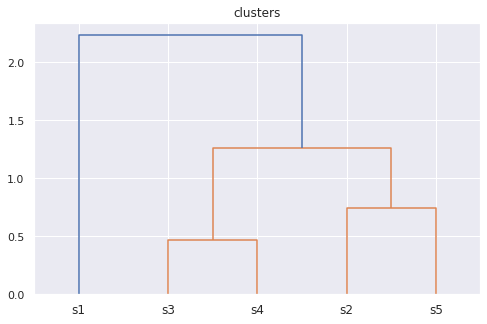

In [159]:
# Scaling
scaler = MinMaxScaler()  
solutions_set_scaled = scaler.fit_transform(solutions_set)
solutions_set_scaled = pd.DataFrame(solutions_set_scaled, columns = solutions_set.columns)

# transpose and convert solutions set to numpy
np_solutions_set = solutions_set_scaled.T.values
# calculate the distances
solutions_set_dist = pdist(np_solutions_set)
# hierarchical clusterization
linked = linkage(solutions_set_dist, 'ward')

# dendrogram
fig = plt.figure(figsize=(8, 5))
dendrogram(linked, labels = solutions_set_scaled.columns)
plt.title('clusters')
plt.show()

Text(0.5, 1.0, 'Submisions of s1 and s5')

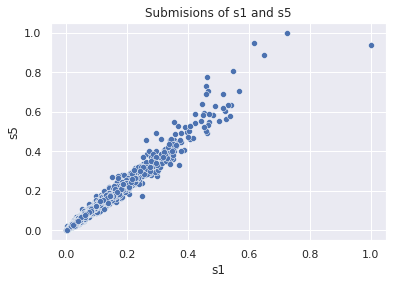

In [160]:
sns.scatterplot(x = 's1', y = 's5', data = solutions_set_scaled)
plt.title('Submisions of s1 and s5')

In [161]:
pred = s1 * 0.4 + (s3 + s4)/2 * 0.3 + (s2 + s5)/2 * 0.3

submission['price'] = pred
submission.to_csv('/aiffel/aiffel/kaggle_kakr_housing/data/submission_blend9.csv', index=False)

[CV] END ......................max_depth=5, n_estimators=500; total time=   6.1s
[CV] END ......................max_depth=5, n_estimators=100; total time=   1.5s
[CV] END ......................max_depth=5, n_estimators=100; total time=   1.9s
[CV] END .....................max_depth=10, n_estimators=500; total time=   8.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   2.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=   1.3s
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=500; total time=   7.2s
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=700; total time=  10.4s
[CV] END ..learning_rate=0.2, max_depth=10, n_estimators=500; total time=   7.5s
[CV] END ..learning_rate=0.2, max_depth=10, n_estimators=700; total time=   9.6s
[CV] END .learning_rate=0.015, max_depth=5, n_estimators=500; total time=   6.9s
[CV] END .learning_rate=0.015, max_depth=5, n_estimators=700; total time=  12.5s
[CV] END learning_rate=0.015

- s1 : scaling 만하고 lgbm : xgb = 6:4로 가중 평균 낸 모델
- 덴드로그램을 통해 데이터의 차이를 파악한 뒤 유사한 것끼리 모아서 평균을 내고 다시 평균을 내주었다

## 최종 결과

### BLEND MODEL
- PRIVATE SCORE : 109197.02671
- PUBLIC SCORE : 108934.24862

![img](img.png)

## 회고

- 데이터 분석을 하다가 시간을 많이 써서 좋은 결과를 내는데 생각보다 시간을 많이 못써서 아쉽다.
    - EDA에서 파악한 인사이트를 바탕으로 실험을 제대로 진행해보지 못해서 아쉬웠다
- 다음에는 시간분배를 좀 더 잘 해봐야겠다
- 생각보다 전처리의 성능향상이 어려웠다
    - 오히려 전처리를 하면 성능이 저하되었다.

추후 추가적으로 해보고 싶은 실험 
- 스태킹 모델
    - 참고 코드 : https://www.kaggle.com/code/bluepinetree/57-of-415-eda-stacking-modeling